In [1]:
!pip install numpy matplotlib

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [1]:
import numpy as np
import matplotlib.pyplot as plt  # <--- 确保你导入了 pyplot 并将其命名为 plt

In [2]:
# =================================================================
# 1. PID 控制器类 
# =================================================================
class PID:
    def __init__(self,Kp,Ki,Kd,setpoint=0,sample_time=0.01,output_limit=100.0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.sample_time = sample_time
        self.output_limit = output_limit #控制输出的绝对最大值

        self.pre_error = 0
        self.integral = 0
        #增加积分项的限制，防止积分饱和
        self.integral_limit = output_limit / Ki if Ki > 0 else 0
    
    def update(self,measured_value):
        #1.计算误差
        error = self.setpoint - measured_value

        #2.计算积分项
        self.integral += error *self.sample_time

        # 积分项核心改进，积分限幅
        # 当积分超过限幅之后，不再累加
        if self.integral_limit > 0:
            self.integral = max(-self.integral_limit,min(self.integral_limit,self.integral))

        #3.计算微分项
        derivative = (error - self.pre_error) / self.sample_time

        #4.计算总控制输出
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative

        #5.存储上一次误差
        self.pre_error = error

        #6.控制输出限幅（模拟电机功率限制）
        output = max(-self.output_limit,min(self.output_limit,output))

        return output

In [3]:
# 2. 虚拟系统模型（模拟机器人关节的物理特性）
# =================================================================

class MotorSystem:
    def __init__(self,initial_angle=0.0,inertia=1.0,damping=0.5,load_torque=0.0):
        self.angle = initial_angle #当前角度
        self.velocity = 0.0 #当前角速度
        self.inertia = inertia #惯性
        self.damping = damping #阻尼
        self.load_torque = load_torque #恒定负载（模拟重力）

    def step(self,control_torque,dt):
        # 净力矩 = 控制器输出 - 摩擦阻尼 - 外部负载
        net_torque = control_torque - self.damping * self.velocity - self.load_torque
        
        # 加速度 = 净力矩 / 惯性 (牛顿第二定律 f=ma)
        acceleration = net_torque / self.inertia
        
        # 速度积分 (欧拉积分)
        self.velocity += acceleration * dt
        
        # 位置积分 (欧拉积分)
        self.angle += self.velocity * dt
        
        return self.angle

In [4]:
# =================================================================
# 3. 仿真主程序
# =================================================================
def run_simulation(Kp,Ki,Kd,setpoint,simulation_time=5.0,load=0.0):
    #初始化参数
    dt = 0.01 #采样时间
    # 💥 优化：延长仿真时间到 10 秒，以便看到完整的响应过程
    simulation_time = 25.0
    num_steps = int(simulation_time / dt)

    #实例化系统和控制器
    motor = MotorSystem(initial_angle = 0.0,load_torque=load)
    pid = PID(Kp,Ki,Kd,setpoint = setpoint,sample_time=dt,output_limit=100.0)#限制最大力矩为10
    
    #记录即使数据
    time_history = []
    angle_history = []

    for i in range(num_steps):
        t = i*dt

        #1.PID计算控制力矩
        control_torque = pid.update(motor.angle)

        #2.系统步进
        current_angle = motor.step(control_torque,dt)

        #3.记录数据
        time_history.append(t)
        angle_history.append(current_angle)

    return time_history,angle_history

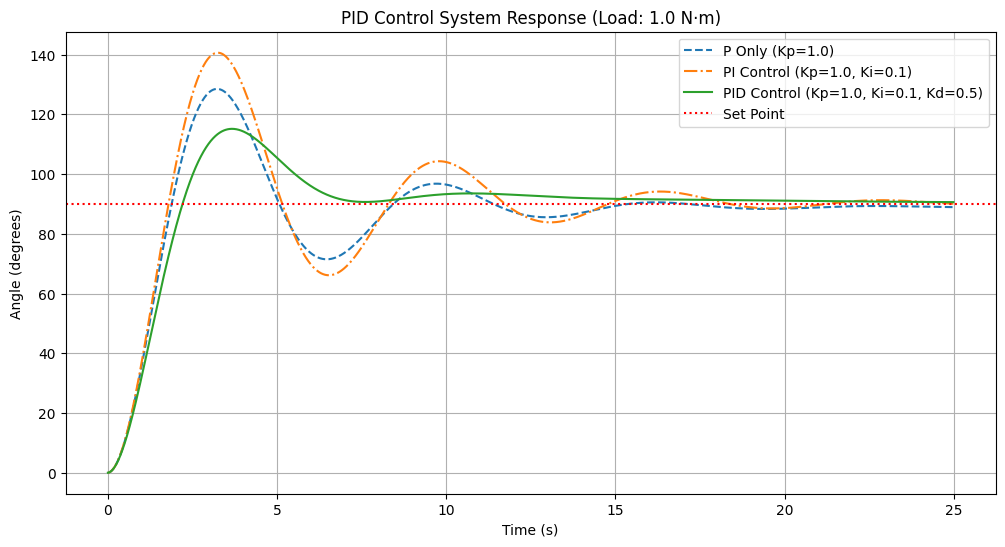

In [7]:
# =================================================================
# 4. 实践和可视化 (关键调试部分)
# =================================================================
# 目标位置
SETPOINT = 90.0
# 模拟重力/负载，如果 load=0，则没有稳态误差。设置为 1.0 可以看到 P 项的局限性。
LOAD_TORQUE = 1.0 

# --- 实验 1: 纯 P 控制 (查看快速性和稳态误差) ---
# Kp 设得较高，让它快点响应，但 Ki 和 Kd 保持 0
Kp1, Ki1, Kd1 = 1.0, 0.0, 0.0
time1, angle1 = run_simulation(Kp1, Ki1, Kd1, SETPOINT, load=LOAD_TORQUE)

# --- 实验 2: 加入 I 控制 (消除稳态误差) ---
# 保持 Kp，增加 Ki 消除稳态误差
Kp2, Ki2, Kd2 = 1.0, 0.1, 0.0
time2, angle2 = run_simulation(Kp2, Ki2, Kd2, SETPOINT, load=LOAD_TORQUE)

# --- 实验 3: 加入 D 控制 (抑制过冲) ---
# 保持 Kp, Ki，增加 Kd 来平抑振荡
Kp3, Ki3, Kd3 = 1.0, 0.1, 0.5
time3, angle3 = run_simulation(Kp3, Ki3, Kd3, SETPOINT, load=LOAD_TORQUE)


# 绘制结果
plt.figure(figsize=(12, 6))

plt.plot(time1, angle1, label=f'P Only (Kp={Kp1})', linestyle='--')
plt.plot(time2, angle2, label=f'PI Control (Kp={Kp2}, Ki={Ki2})', linestyle='-.')
plt.plot(time3, angle3, label=f'PID Control (Kp={Kp3}, Ki={Ki3}, Kd={Kd3})', linestyle='-')

# 绘制目标值
plt.axhline(SETPOINT, color='r', linestyle=':', label='Set Point') # 目标角度 (Set Point) -> Set Point

plt.title(f'PID Control System Response (Load: {LOAD_TORQUE} N·m)') # PID 控制系统响应对比 (负载: {LOAD_TORQUE} N·m) -> PID Control System Response
plt.xlabel('Time (s)') # 时间 (秒) -> Time (s)
plt.ylabel('Angle (degrees)') # 角度 (度) -> Angle (degrees)
plt.legend()
plt.grid(True)
plt.show()